In [2]:
%%capture --no-stderr
%pip install --quiet -U langsmith langgraph langgraph-cli langchain_google_genai langgraph-checkpoint-postgres psycopg psycopg-pool psycopg-binary tavily-python langchain_community python-dotenv langchain-core==0.3.21 pydantic==2.8.2 pydantic-settings==2.5.2 packaging==23.2

In [3]:
import os
from IPython.display import Image, display
from typing import Literal, Dict, Union, Optional
from psycopg_pool import ConnectionPool
from langgraph.checkpoint.postgres import PostgresSaver
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import ToolNode
from langchain.schema.runnable.config import RunnableConfig
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage, RemoveMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import MessagesState
from io import BytesIO
from pydantic import BaseModel
from langgraph.checkpoint.memory import MemorySaver

e:\Rida\PIAIC\Quarter4\chatbot\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
NEON_DB_URI = os.getenv("NEON_DB_URI")

os.environ["TAVILY_API_KEY"]= os.getenv("TAVILY_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "chatbot"

In [6]:
# Postgres DB

# # Connection pool for efficient database access
# connection_kwargs = {"autocommit": True, "prepare_threshold": 0}

# # Create a persistent connection pool
# pool = ConnectionPool(conninfo=NEON_DB_URI, max_size=50, kwargs=connection_kwargs)

# # Initialize PostgresSaver checkpointer
# checkpointer = PostgresSaver(pool)
# checkpointer.setup()  # Ensure database tables are set up

memory = MemorySaver()

In [27]:
# State

class State(MessagesState):
    summary: str
    ask_doctor: bool

In [28]:
class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert Doctor. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert Doctor can provide the right guidance.
    """

    request: str

In [29]:
# Tavily Search Tool Node

search_tool = TavilySearchResults(max_results=2, search_depth="advanced")
tools = [search_tool]

tool_node = ToolNode(tools=[search_tool])

In [30]:
# Model

model = ChatGoogleGenerativeAI(
    model="gemini-pro",
    api_key=GEMINI_API_KEY,
    temperature=0.2
)

model = model.bind_tools(tools + [RequestAssistance])

In [31]:
# Helper Function
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def doctor_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from Doctor.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_doctor": False,
    }

In [32]:
# Summarization

def summarize_conversation(state: State) -> State:
    """
    Summarizes the conversation if the number of messages exceeds 6 messages.
    
    Args:
        state (State): The current conversation state.
        model (object): The model to use for summarization.

    Returns:
        Dict[str, object]: A dictionary containing updated messages.
    """
   
    # Get any existing summary
    summary = state.get("summary", "")

    # Create summarization prompt based on whether there is an existing summary
    if summary:
        summary_message = (
            f"This is the summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add the summarization prompt to the conversation history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Save summary and truncate old messages
    state["summary"] = response.content
    state["messages"] = state["messages"][-2:]  # Keep only the last 2 messages

In [33]:
# Conditional Function

def select_next_node(state: State) -> Union[Literal["tools", "summarize", "doctor"], str]:
    # Check if the conversation requires human intervention
    if state["ask_doctor"]:
        return "doctor"

    messages = state["messages"]
    last_message = messages[-1]

    # If there are more than six messages, route to "summarize_conversation"
    if len(messages) > 6:
        return "summarize"
    
    # If the LLM makes a tool call, route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    
    # Otherwise, route to "final" or end
    return END

In [34]:
# Invoke Messages

def call_model(state: State) -> Dict[str, object]:

    # Ensure state contains 'messages'
    if "messages" not in state:
        raise ValueError("State must contain a 'messages' key.")
    
    # Initialize messages from the state
    messages = state["messages"]
    
    # Check if a summary exists and prepend it as a system message if present
    summary = state.get("summary", "")
    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + messages

    # Safely invoke the model
    try:
        response = model.invoke(messages)
        ask_doctor = False

        if (
            response.tool_calls
            and response.tool_calls[0]["name"] == RequestAssistance.__name__
        ):
            ask_doctor = True

    except Exception as e:
        raise RuntimeError(f"Error invoking the model: {e}")

    # Append the response to messages
    messages.append(response)

    # Return the updated state with messages
    return {"messages": messages[-1], "ask_doctor": ask_doctor}

In [35]:
# Build Graph

builder = StateGraph(State)

builder.add_node("agent", call_model)
builder.add_node("tools", tool_node)
builder.add_node("doctor", doctor_node)
builder.add_node("summarize", summarize_conversation)

builder.add_edge(START, "agent")
builder.add_edge("tools", "agent")
builder.add_edge("doctor", "agent")
builder.add_edge("summarize", END)

builder.add_conditional_edges(
    "agent",
    select_next_node,
    {"summarize": "summarize", "doctor": "doctor", "tools": "tools", END: END},
)

graph = builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["doctor"]
    )

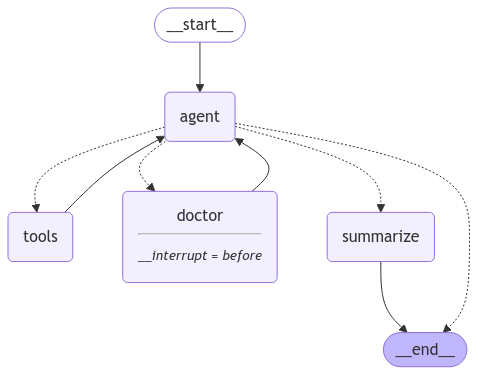

In [36]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (e14ff43f-fe93-4c5d-b36e-437e6bd7069e)
 Call ID: e14ff43f-fe93-4c5d-b36e-437e6bd7069e
  Args:
    request: I need some expert guidance for building this AI agent.


In [38]:
snapshot = graph.get_state(config)
snapshot.next

('doctor',)

In [39]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(human_response, ai_message)

graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efbc7de-9873-65cd-8008-214ea6145b86'}}

In [40]:
events = graph.stream(None, config, stream_mode="values")

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
